In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import langid
import re
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import pickle
import arabic_reshaper
from bidi.algorithm import get_display
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
df = pd.read_excel("Complaints dataset.xlsx")

In [3]:
preprocessed_df = pd.read_csv("preprocessed_data.csv", low_memory=False)

In [4]:
preprocessed_df

,OFFER_NAME,CUSTOMER_TYPE,COMPLAINT_TYPE,PRODUCT,CASE_LEVEL_1,CASE_LEVEL_2,CASE_LEVEL_3,CUSTOMER_GROUP,CURRENT_STATUS,ESCALATION_FLAG,...,AGE_BRACKET,ACTUAL_COMPLAINT,CALLBACK_MECHANISM,RESOLUTION,RESOLUTION_DESCRIPTION,CASE_DESC,OPEN_GR,Unnamed: 22,Unnamed: 23,preprocessed_text
0,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_INTERNET_CONFIGURATION,SNW-FTTH - WAN configuration / Tools,FTTH Home,Resolved,No,...,1,User Not Filled,NaN,NaN,NaN,إعادة برمجة من النظامby Sultan,NaN,NaN,NaN,إعاد رمج نظامby Sultan
1,NaN,CBU,Technical,Mobile,Technical complaint,TC_INTERNET_CONNEXION,4G - Frequent Disconnection,NaN,Resolved,Yes,...,1,Actual Complaint,SMS,Coverage script was sent to the customer,The customer should pay TF + all due amounts i...,عدم التصفح وسوء الخدمه والرجاء اتخاذ قرار ...,System Administrator,NaN,NaN,عدم تصفح سوء خدمه رجاء تخاذ قرار سك رويشد واء ...
2,Super 4G on the go 100GB new,CBU,Commercial,Mobile,Commercial claim,CC_Offers,Embedded Bundle - Didn't Get The Monthly Bundles,Family Mobile-IEW,Resolved,Yes,...,1,Actual Complaint,SMS,IEW offer -no link,the line is active now & linked & getting the ...,Activation date Sep 22 2022 لم يتم اضافة ا...,NaN,NaN,NaN,Activation date Sep 22 2022 تم اضاف حزم رقم تو...
3,Pro Bitstream,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-ADSL-Individual fault,Internet SME,Resolved,No,...,1,User Not Filled,NaN,NaN,NaN,GAIA,NaN,NaN,NaN,gaia
4,FTTH Home,CBU,Technical,Internet,Technical complaint,TC_Network,SNW-FTTH - Down interrupted,FTTH Home,Resolved,No,...,1,User Not Filled,NaN,NaN,NaN,Interrupted,NaN,NaN,NaN,interrupt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276287,Pro BEW 1.2 TB,CBU,Technical,Mobile,Technical complaint,TC_Network,4G+ - No Connection Signal,SME Post-Hybrid,Resolved,No,...,1,User Not Filled,NaN,NaN,NaN,ئئسسسئ,CBU - CC 1st Layer,NaN,NaN,ئئسسسئ
276288,Super IEW 4G 2Y - 500GB - EOY,CBU,Technical,Mobile,Technical complaint,TC_INTERNET_CONNEXION,4G+ - Slow Download,Internet everywhere IEW,Resolved,No,...,1,User Not Filled,NaN,NaN,NaN,ئئئ,CBU - CC 1st Layer,NaN,NaN,ئئئ
276289,Super 4G on the go 100GB paid,EBU,Technical,Mobile,Technical complaint,TC_Network,4G+ - No Connection Signal,Business Account,Resolved,No,...,1,User Not Filled,NaN,NaN,NaN,ئئئء,CBU - CC 1st Layer,NaN,NaN,ئئئء
276290,Prepaid residential Basic,CBU,Commercial,Mobile,Commercial claim,CC_Consumption,Usage Bundles - Data,Prepaid,Resolved,No,...,1,User Not Filled,NaN,NaN,NaN,ئئئئ,CBU - CC 1st Layer,NaN,NaN,ئئئئ


In [5]:
import pandas as pd
import re
import langid
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tashaphyne.stemming import ArabicLightStemmer
from nltk.stem import PorterStemmer
import nltk

stop_words_english = set(stopwords.words('english'))

stop_words_arabic = set(stopwords.words('arabic'))

def preprocess_text(text, language):
    if language == 'en':
        # English pre-processing
        tokens = nltk.word_tokenize(text)
        tokens = [token.lower() for token in tokens if re.match(r'\w', token)]
        tokens = [token for token in tokens if token not in stop_words_english]
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]
    elif language == 'ar':
        # Arabic pre-processing
        text = remove_diacritics(text)
        text = re.sub(r'[^\w\s]', '', text)
        words = word_tokenize(text)
        words = [word for word in words if word.lower() not in stop_words_arabic]
        stemmer = ArabicLightStemmer()
        words = [stemmer.light_stem(word) for word in words]
        tokens = words
    else:
        tokens = nltk.word_tokenize(text)

    processed_text = ' '.join(tokens)
    return processed_text

def remove_diacritics(text):
    arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', str(text))
    return text

##   Graph

In [6]:
import arabic_reshaper
from bidi.algorithm import get_display
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
def arabic_display(text):
    reshaped_text = arabic_reshaper.reshape(text)
    return get_display(reshaped_text)

C:\Users\USER\anaconda3\lib\tkinter\__init__.py:1429: DtypeWarning: Columns (15,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  self.tk.mainloop(n)
C:\Users\USER\anaconda3\lib\tkinter\__init__.py:1892: DtypeWarning: Columns (15,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  return self.func(*args)
C:\Users\USER\anaconda3\lib\site-packages\mplcursors\_pick_info.py:162: UserWarning: Pick support for FancyArrowPatch is missing.
  warnings.warn(f"Pick support for {type(artist).__name__} is missing.")


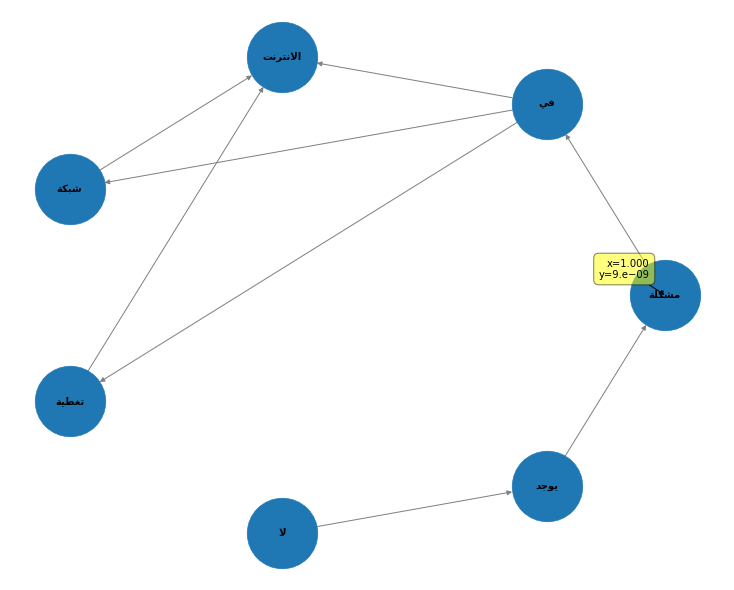

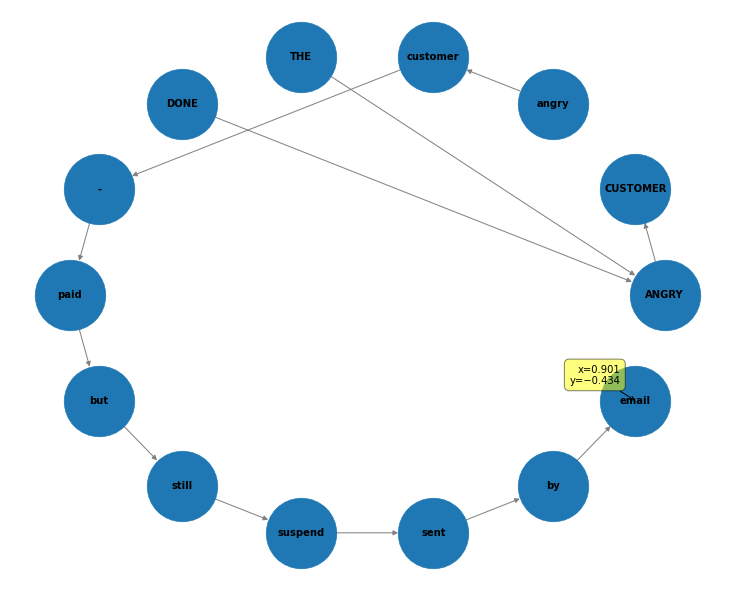

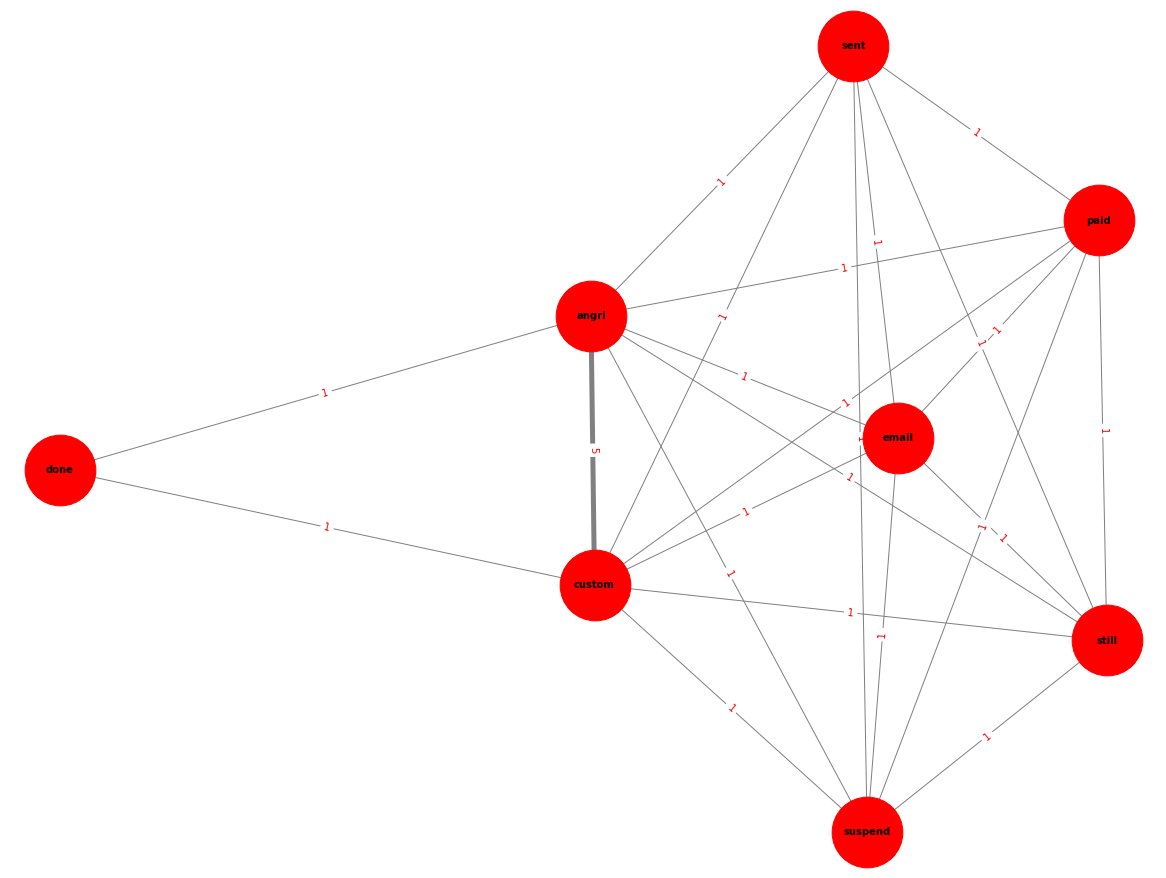

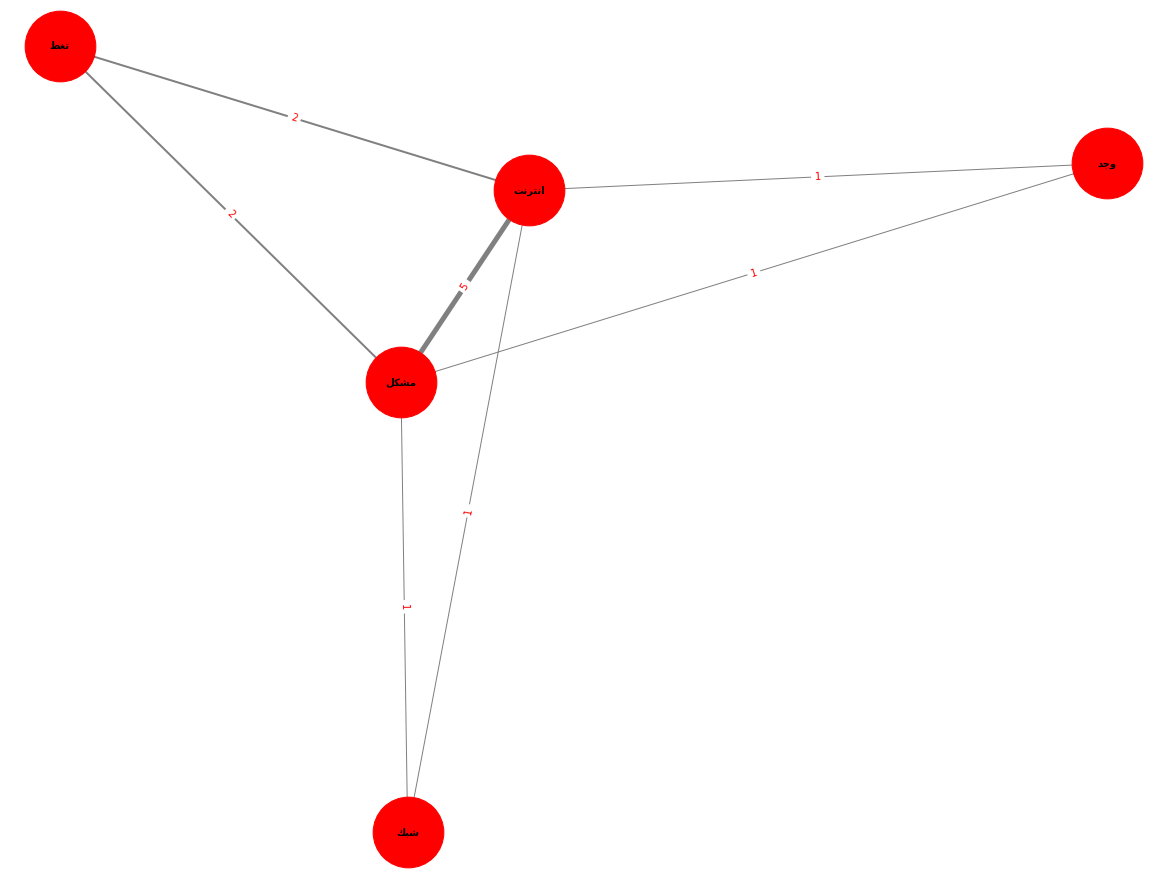

In [7]:
import tkinter as tk
from tkinter import messagebox
from tkinter import ttk
import os
import subprocess
import mplcursors

def text_mining(user_query):
    preprocessed_df = pd.read_csv("preprocessed_data.csv")

    preprocessed_query = preprocess_text(user_query, langid.classify(user_query)[0])

    combined_text = preprocessed_df['CASE_DESC'].append(pd.Series([user_query]))

    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(combined_text)

    cosine_similarities = cosine_similarity(tfidf_matrix[-1], tfidf_matrix[:-1])

    # The indices of the top 5 most similar documents
    most_similar_indices = np.argsort(cosine_similarities[0])[:-6:-1]

    results_df = pd.DataFrame({
        'Original Document': [df.loc[index, 'CASE_DESC'] for index in most_similar_indices],
        'Cosine Similarity': [cosine_similarities[0][index] for index in most_similar_indices]})
    results_df.to_csv('similar_documents_results.csv', index=False)
    
    preprocessed_texts_top_5 = preprocessed_df.loc[most_similar_indices, 'preprocessed_text'].tolist()
    
    return results_df, most_similar_indices

def directed_graph(results_window, user_query):
    results_df, _ = text_mining(user_query)

    G = nx.DiGraph()

    # Add nodes and edges based on document words
    for idx, row in results_df.iterrows():
        document_words = row['Original Document'].split()
        for i in range(len(document_words) - 1):
            edge = (document_words[i], document_words[i + 1])
            G.add_edge(*edge)

    plt.figure(figsize=(10, 8))  
    pos = nx.circular_layout(G)

    node_labels = {node: arabic_display(node) for node in G.nodes}
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=5000, font_size=10, font_color='black', font_weight='bold', edge_color='gray', linewidths=0.5, labels=node_labels)
    
    plt.savefig("Directed_Graph.png", format="PNG")

    canvas = FigureCanvasTkAgg(plt.gcf(), master=results_window)
    canvas.draw()

    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    
    mplcursors.cursor(hover=True)

    button_centrality_measures = tk.Button(results_window, text="Centrality Measures", command=lambda: show_centrality_measures(G))
    button_centrality_measures.pack(pady=10)

def weighted_graph(results_window, user_query, preprocessed_texts_top_5):
    
    # To calculate the co-ocurrences
    co_occurrences_dict = count_co_occurrences(preprocessed_texts_top_5)
    
    results_df, _ = text_mining(user_query)
    
    G = nx.Graph()

    # Iterate over the co-occurrences dictionary
    for word, co_occurrences in co_occurrences_dict.items():
        for neighbor, weight in co_occurrences.items():
            # Add nodes and edges to the graph
            G.add_edge(word, neighbor, weight=weight)
            
    # To make the arabic words unsplit
    node_labels = {node: arabic_display(node) for node in G.nodes}

    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(G, k=1.0)  
    nx.draw(G, pos, with_labels=True, font_size=10, font_color='black', font_weight='bold', node_size=5000, node_color='red', edge_color='gray', width=[float(d['weight']) for (u, v, d) in G.edges(data=True)], edge_cmap=plt.cm.Blues, labels=node_labels)
    
    # Add edge labels with weights
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.savefig("Weighted_Graph.png", format="PNG")

    canvas = FigureCanvasTkAgg(plt.gcf(), master=results_window)
    canvas.draw()

    canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    
def count_co_occurrences(preprocessed_texts):
    co_occurrences_dict = defaultdict(dict)
    for text in preprocessed_texts:
        words = text.split()

        for i in range(len(words)):
            # Check if the word is already in the dictionary
            if words[i] not in co_occurrences_dict:
                co_occurrences_dict[words[i]] = defaultdict(int)

            for j in range(i + 1, len(words)):
                # Check if the word is already in the inner dictionary
                if words[j] not in co_occurrences_dict[words[i]]:
                    co_occurrences_dict[words[i]][words[j]] = 0

                co_occurrences_dict[words[i]][words[j]] += 1
    return co_occurrences_dict
                
def run_text_mining():
    user_query = entry_query.get()
    results_df, most_similar_indices = text_mining(user_query)
    messagebox.showinfo("Text Mining", "Text mining completed successfully.")
    results_window = tk.Toplevel(root)
    results_window.title("Text Mining Results")
    tree = ttk.Treeview(results_window, columns=list(results_df.columns), show='headings')

    for col in results_df.columns:
        tree.heading(col, text=col)
        tree.column(col, width=150)

    for _, row in results_df.iterrows():
        tree.insert("", "end", values=list(row))

    tree.pack(expand=True, fill='both')

def run_directed_graph():
    user_query = entry_query.get()
    results_window = tk.Toplevel(root)
    results_window.title("Directed Graph Results")
    directed_graph(results_window, user_query)
    messagebox.showinfo("Directed Graph", "Directed graph completed successfully.")

def run_weighted_graph():
    user_query = entry_query.get()
    results_df, most_similar_indices = text_mining(user_query)
    results_window = tk.Toplevel(root)
    results_window.title("Weighted Graph Results")
    preprocessed_texts_top_5 = preprocessed_df.loc[most_similar_indices, 'preprocessed_text'].tolist()
    weighted_graph(results_window, user_query, preprocessed_texts_top_5)
    messagebox.showinfo("Weighted Graph", "Weighted graph completed successfully.")

def show_centrality_measures(graph):
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)

    # Create a DataFrame for each centrality measure
    degree_df = pd.DataFrame(list(degree_centrality.items()), columns=['Node', 'Degree Centrality'])
    betweenness_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Node', 'Betweenness Centrality'])
    closeness_df = pd.DataFrame(list(closeness_centrality.items()), columns=['Node', 'Closeness Centrality'])

    display_tables(degree_df, betweenness_df, closeness_df)

def display_tables(*dataframes):
    tables_window = tk.Toplevel()
    tables_window.title("Centrality Measures Tables")

    notebook = ttk.Notebook(tables_window)
    notebook.pack(fill='both', expand=True)

    for i, df in enumerate(dataframes, 1):
        tab = ttk.Frame(notebook)
        notebook.add(tab, text=f"Table {i}")

        tree = ttk.Treeview(tab, columns=list(df.columns), show='headings')

        for col in df.columns:
            tree.heading(col, text=col)
            tree.column(col, width=150)

        for _, row in df.iterrows():
            tree.insert("", "end", values=list(row))

        tree.pack(expand=True, fill='both')
    
# Main window
root = tk.Tk()
root.title("Mining Application")

# Widgets
label_query = tk.Label(root, text="Enter your query:")
label_query.pack(pady=10)

entry_query = tk.Entry(root)
entry_query.pack(pady=10)

button_text_mining = tk.Button(root, text="Run Text Mining", command=run_text_mining)
button_text_mining.pack(pady=10)

button_directed_graph = tk.Button(root, text="Directed Graph", command=run_directed_graph)
button_directed_graph.pack(pady=10)

button_weighted_graph = tk.Button(root, text="Weighted Graph", command=run_weighted_graph)
button_weighted_graph.pack(pady=10)

root.mainloop()